In [4]:
!pip install mrcfile opencv-python tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import mrcfile
import numpy as np
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [6]:
# Define the filename
mrc_file_path = '/nas/vruiz/cryoCARE/epfl1/epfl1_subset1_float.mrc'

# Open the MRC file
try:
    with mrcfile.open(mrc_file_path) as mrc:
        # Get the data as a NumPy array
        original_volume = mrc.data
        
        # Print header information
        print(f"File loaded successfully: {mrc_file_path}")
        print(f"Data shape (Z, Y, X): {original_volume.shape}")
        print(f"Data type: {original_volume.dtype}")
        print(f"Voxel size (Å): ({mrc.voxel_size.x:.2f}, {mrc.voxel_size.y:.2f}, {mrc.voxel_size.z:.2f})")

except FileNotFoundError:
    print(f"Error: The file {mrc_file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

File loaded successfully: /nas/vruiz/cryoCARE/epfl1/epfl1_subset1_float.mrc
Data shape (Z, Y, X): (150, 768, 1024)
Data type: float32
Voxel size (Å): (1.00, 1.00, 1.00)


In [20]:
# --- 1. Normalize Volume for Optical Flow Calculation ---
# OpenCV's Farneback algorithm requires 8-bit grayscale images.
def normalize_volume_to_uint8(volume):
    """Normalizes a float32 volume to the 0-255 range and converts to uint8."""
    vol_min = volume.min()
    vol_max = volume.max()
    if vol_max > vol_min:
        normalized = 255 * (volume - vol_min) / (vol_max - vol_min)
    else:
        normalized = np.zeros_like(volume) # Handle flat volume
    return normalized.astype(np.uint8)

volume_uint8 = normalize_volume_to_uint8(volume_data)
print(f"Volume normalized to uint8 for OpenCV.")

# --- 2. Initialize New Volume and Set Optical Flow Parameters ---
projected_volume = np.zeros_like(original_volume, dtype=np.float32)

# Parameters for Gunnar Farneback's algorithm
# These are standard defaults, but can be tuned for specific datasets
farneback_params = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

# --- 3. Loop Through Slices, Calculate Flow, and Warp ---
# We iterate up to the second-to-last slice.
for z in tqdm(range(original_volume.shape[0] - 1), desc="Projecting Slices"):
    # Target slice is 'z', the one we move is 'z+1'
    # Use the uint8 versions to calculate flow
    slice_z = volume_uint8[z, :, :]
    slice_z_plus_1 = volume_uint8[z + 1, :, :]

    # Calculate the dense optical flow from slice_z_plus_1 to slice_z
    flow = cv2.calcOpticalFlowFarneback(slice_z, slice_z_plus_1, None, **farneback_params)
    
    # Create a remapping grid from the flow field
    height, width = flow.shape[:2]
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    
    # The new map tells where each pixel in the output image should come from in the input image
    map_x = (x_coords + flow[..., 0]).astype(np.float32)
    map_y = (y_coords + flow[..., 1]).astype(np.float32)

    # Warp the *original float32 slice* using the map for maximum precision
    original_slice_to_warp = original_volume[z + 1, :, :]
    projected_slice = cv2.remap(
        src=original_slice_to_warp,
        map1=map_x,
        map2=map_y,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE # Handle edge pixels
    )
    
    # Store the result
    projected_volume[z, :, :] = projected_slice

# The last slice has no 'z+1', so we just copy it from the original.
projected_volume[-1, :, :] = original_volume[-1, :, :]

print("\nOptical flow calculation and projection complete.")

Volume normalized to uint8 for OpenCV.


Projecting Slices:   0%|          | 0/149 [00:00<?, ?it/s]


Optical flow calculation and projection complete.


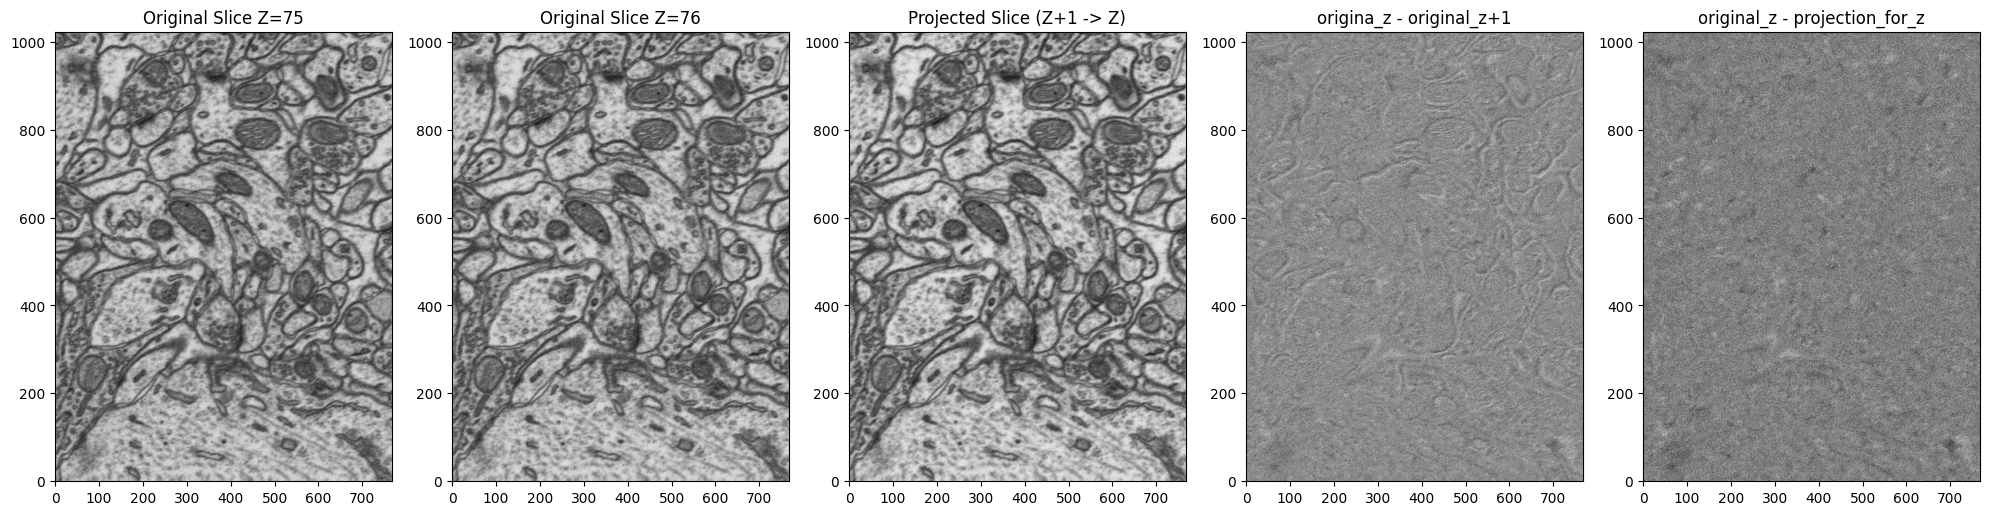

In [21]:
# Choose a slice index in the middle of the volume for a good comparison
slice_idx = original_volume.shape[0] // 2

fig, axes = plt.subplots(1, 5, figsize=(20, 20))

# Plot the original slice z
im1 = axes[0].imshow(original_volume[slice_idx, :, :].T, cmap='gray', origin='lower')
axes[0].set_title(f'Original Slice Z={slice_idx}')
axes[0].grid(False)

# Plot the original slice z+1
im2 = axes[1].imshow(original_volume[slice_idx + 1, :, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Original Slice Z={slice_idx + 1}')
axes[1].grid(False)

# Plot the projected slice (z+1 warped onto z)
im3 = axes[2].imshow(projected_volume[slice_idx, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Projected Slice (Z+1 -> Z)')
axes[2].grid(False)

# Plot the projected slice (z+1 warped onto z)
im4 = axes[3].imshow(original_volume[slice_idx, :, :].T - original_volume[slice_idx + 1, :, :].T, cmap='gray', origin='lower')
axes[3].set_title(f'origina_z - original_z+1')
axes[3].grid(False)

# Plot the projected slice (z+1 warped onto z)
im4 = axes[4].imshow(original_volume[slice_idx, :, :].T - projected_volume[slice_idx, :, :].T, cmap='gray', origin='lower')
axes[4].set_title(f'original_z - projection_for_z')
axes[4].grid(False)

plt.tight_layout()
plt.show()

In [22]:
output_filename = 'projected_volume.mrc'

try:
    with mrcfile.new(output_filename, overwrite=True) as mrc:
        # Set the main data block
        mrc.set_data(projected_volume.astype(np.float32))
        
        # Copy the header and voxel size from the original file
        mrc.header.update(original_header)
        mrc.voxel_size = voxel_size
        
        # Update statistics in the header
        mrc.update_header_from_data()
        mrc.update_header_stats()
        
    print(f"New MRC file '{output_filename}' was created successfully.")
    print(f"Data shape: {mrc.data.shape}")
    print(f"Voxel size: {mrc.voxel_size}")

except Exception as e:
    print(f"An error occurred while saving the file: {e}")

An error occurred while saving the file: recarray has no attribute update
